In [1]:
import itertools as it
import numpy as np
%matplotlib inline

In [2]:
def resample(data, B):
    """
    Return `B` bootstrap samples of `data` as a generator.
    The motivation of this is that it may be desirable to
    calculate several functionals of the bootstrapped data.
    Args:
        data (np.array): numpy array
        B (int): the number of pseduo-datasets to be created
    Returns:
        (PyGenObject): generator of numpy arrays of size data.shape[0]
    """
    to_be_sampled = data.ravel()
    for _ in xrange(0, B):
        yield np.random.choice(a=to_be_sampled, size=data.shape[0], replace=True)
    
def estimate(data_gen, estimators):
    """
    For every statistic in estimators, create an
    itertools.tee so that the samples in data_gen
    can be consumed for each estimator. Returns a
    dictionary of the form
        statistic: sampling distribution of statistic
    This can easily be passed e.g. to the pandas.DataFrame
    constructor for visualization, etc.
    Args:
        data_gen (PyGenObject): generator of samples 
                                (usually np.array)
        estimators (iterable of callables): the functions 
                                            to perform on the
                                            samples
    Returns:
        (dict): keys are names of estimators; values are 
                resulting arrays of estimator(sample)
    """
    # One more tee is created to ascertain # samples in data_gen
    tees = it.tee(data_gen, len(estimators) + 1)
    len_gen, sample_gens = tees[0], tees[1:]
    del tees
    num_samples = sum(1 for _ in len_gen)
    # izip object of (callable, it.tee)
    estimators_and_sample_gens = it.izip(estimators, sample_gens)
    # generator of tuples of (estimator_name, estimator.__cal__(sample_gen))
    estimators_and_distributions = ((estimator.__name__, it.imap(estimator, sample_gen))
                                   for estimator, sample_gen in estimators_and_sample_gens)
    return {estimator: np.fromiter(sampling_dist_element, dtype=float, count=num_samples)
           for estimator, sampling_dist_element in estimators_and_distributions}

# Estimate the median and mean of a synthetic dataset.
Imagine that we have limited data for our process, say, 10 elements. This obviously
limits our inference. Assuming that these data, $(x_1, ..., x_{10})$ are realizations of 
$X_1, ..., X_{10} \sim F(\theta)$, inference about $\theta$ are clearly limited. One
solution to this is let randomness work _for you_ by using the Bootstrap.

In [3]:
# Generate our 10 x values
observed = np.random.ranf(10)

# Sample from these 10 data. This function returns
# a generator because B usually is set to be very large;
# as close to len(observed) to the power of len(observed),
# the better
bootstrap_samples_gen = resample(observed, B=100)

# Yield bootstrapped sampling distributions for any iterable
# of estimators. Here, just mean and median
estimators_and_sampling_distns = estimate(bootstrap_samples_gen,
                                          estimators=[np.median, np.mean])

In [4]:
estimators_and_sampling_distns

{'mean': array([ 0.59244407,  0.73246056,  0.72528875,  0.62060392,  0.53282264,
         0.56774848,  0.70790288,  0.70867651,  0.67585216,  0.67285468,
         0.6256923 ,  0.72954076,  0.50393458,  0.6005821 ,  0.75860422,
         0.5832028 ,  0.68034667,  0.6634139 ,  0.65463575,  0.59872113,
         0.5270956 ,  0.42352838,  0.58868418,  0.73370331,  0.4844081 ,
         0.56865141,  0.67245737,  0.38754867,  0.62287288,  0.66363099,
         0.56411423,  0.67795769,  0.59639474,  0.68178246,  0.64798543,
         0.48498391,  0.66811143,  0.56622434,  0.62007104,  0.65574374,
         0.62626075,  0.65675566,  0.46504711,  0.61248378,  0.6977888 ,
         0.59465203,  0.76864012,  0.50685233,  0.6082252 ,  0.59157337,
         0.53033639,  0.65554073,  0.66234173,  0.60454344,  0.44438822,
         0.65999495,  0.43814309,  0.58093737,  0.71760429,  0.66686542,
         0.66398385,  0.49564003,  0.74653243,  0.59412373,  0.60943779,
         0.70295661,  0.47657346,  0.563025

In [5]:
# Let's make a DataFrame and plot it
import pandas as pd
df = pd.DataFrame(estimators_and_sampling_distns)

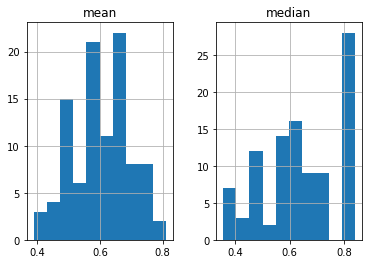

In [6]:
df.hist();

In [7]:
bootstrap_hundred_thousand = resample(observed, B=100000)

In [8]:
bootstrapped_estimators = estimate(data_gen=bootstrap_hundred_thousand,
                                   estimators=[np.median, np.mean])

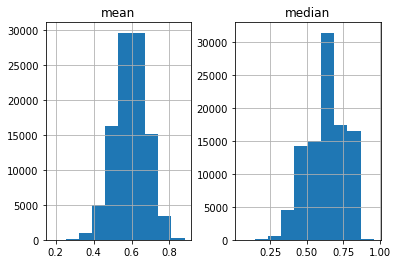

In [9]:
df_hundred_thousand = pd.DataFrame(bootstrapped_estimators)
df_hundred_thousand.hist();

In [10]:
print np.mean(observed)
print np.median(observed)

0.594521037437
0.644767681521
